## Studying Growth Instability with two possible facets

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_r$ (reduction in supersaturation at facet centers relative to corners)
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

These are specified as small departures from a baseline scenario, taken from *Parameter Baseline*, which tries to come up with a self-consistent set of parameters at given values of:
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize
from matplotlib import rcParams

import sys
sys.path.append('..')
import QLCstuff as QLC

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### These are parameters we're not planning on varying

In [3]:
# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)
print('Nbar =', Nbar)
print('Nstar =', Nstar)

# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')
print('tau_eq =',tau_eq)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Thickness of a monolayer (have to decide which of these we want)
# nmpermonolayer = AssignQuantity(0.3,'nanometer')
nmpermonolayer = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('nmpermonolayer =', nmpermonolayer)

# Other baseline values
D_baseline = AssignQuantity(3.65e-04,'micrometer^2/microsecond'); print('D_baseline =',D_baseline)
nu_kin_baseline = AssignQuantity(105,'micrometer/second'); print('nu_kin_baseline =', nu_kin_baseline)
L_baseline = AssignQuantity(30,'micrometer'); print('L_baseline =', L_baseline)

Nbar = 1.0
Nstar = 0.1432394487827058
tau_eq = 1 microsecond
sigma0 = 0.2
nmpermonolayer = 0.389 nanometer
D_baseline = 0.000365 micrometer ** 2 / microsecond
nu_kin_baseline = 105 micrometer / second
L_baseline = 30 micrometer


### Parameters we might vary

In [4]:
# Defining scenarios
# sigmaI_corner_baseline = AssignQuantity(0.244,'dimensionless') 
sigmaI_corner_baseline = AssignQuantity(0.22,'dimensionless') 
c_r_percent_baseline = AssignQuantity(1.068,'dimensionless')
c_r_baseline = c_r_percent_baseline/100
tau_eq_baseline = AssignQuantity(1.0,'microsecond')
odemethod = 'RK23' # Explicit Runge-Kutta  
odemethod = 'DOP853' # Explicit Runge-Kutta (order 8)
odemethod = 'LSODA' # Adams/BDF method 
odemethod = 'Radau' # Implicit Runge-Kutta of the Radau IIA family of order 5 (takes ~200x explicit methods)
odemethod = 'RK45' # Explicit Runge-Kutta
# odemethod = 'BDF' # Implicit multi-step variable-order (1 to 5) method (takes ~100x explicit methods)

In [5]:
parameter_names = ['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']; print(parameter_names)
result_names = ['g_ice_QLC', 'lambda_average', 'alpha']; print(result_names)

['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']
['g_ice_QLC', 'lambda_average', 'alpha']


### Make a list of parameter sets

In [6]:
parameterlist_mag = []

# Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.215, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.209, c_r_percent_baseline.magnitude, 3])

parameterlist_mag.append(
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
     0.208, c_r_percent_baseline.magnitude, 5])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.21, c_r_percent_baseline.magnitude, 2])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, 105, 
#      0.21, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, 5e-04, 105, 
#      0.21, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Varying the diffusion coefficient
# parameterlist_mag.append(
#     [L_baseline.magnitude, 0.0002, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Varying the freezing time constant
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude,  
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, 1.1])

# # Varying the kinetic velocity 
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, 110, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, 1.0, tau_eq_baseline.magnitude])

print(parameterlist_mag)

[[30, 0.000365, 105, 0.208, 1.068, 5]]


### Run the list

L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_kin_mlyperus = 0.26992287917737784 / microsecond
sigmaI_corner = 0.208 dimensionless
c_r_percent = 1.068 dimensionless
odemethod = RK45
nx (crystal) = 320
Spacing of points on the ice surface = 0.18808777429467227 micrometer
dtmax = 48.46165868373093 microsecond
Estimating times for the trajectory run
   time (est) =  47.781848256749655 millisecond
   time (used) =  100 millisecond
   dt = 200.40080160320642 microsecond
10 % elapsed time is 0.013 minutes
20 % elapsed time is 0.025 minutes
30 % elapsed time is 0.037 minutes
40 % elapsed time is 0.048 minutes
50 % elapsed time is 0.060 minutes
60 % elapsed time is 0.072 minutes
70 % elapsed time is 0.084 minutes
80 % elapsed time is 0.096 minutes
90 % elapsed time is 0.108 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success

<IPython.core.display.Javascript object>


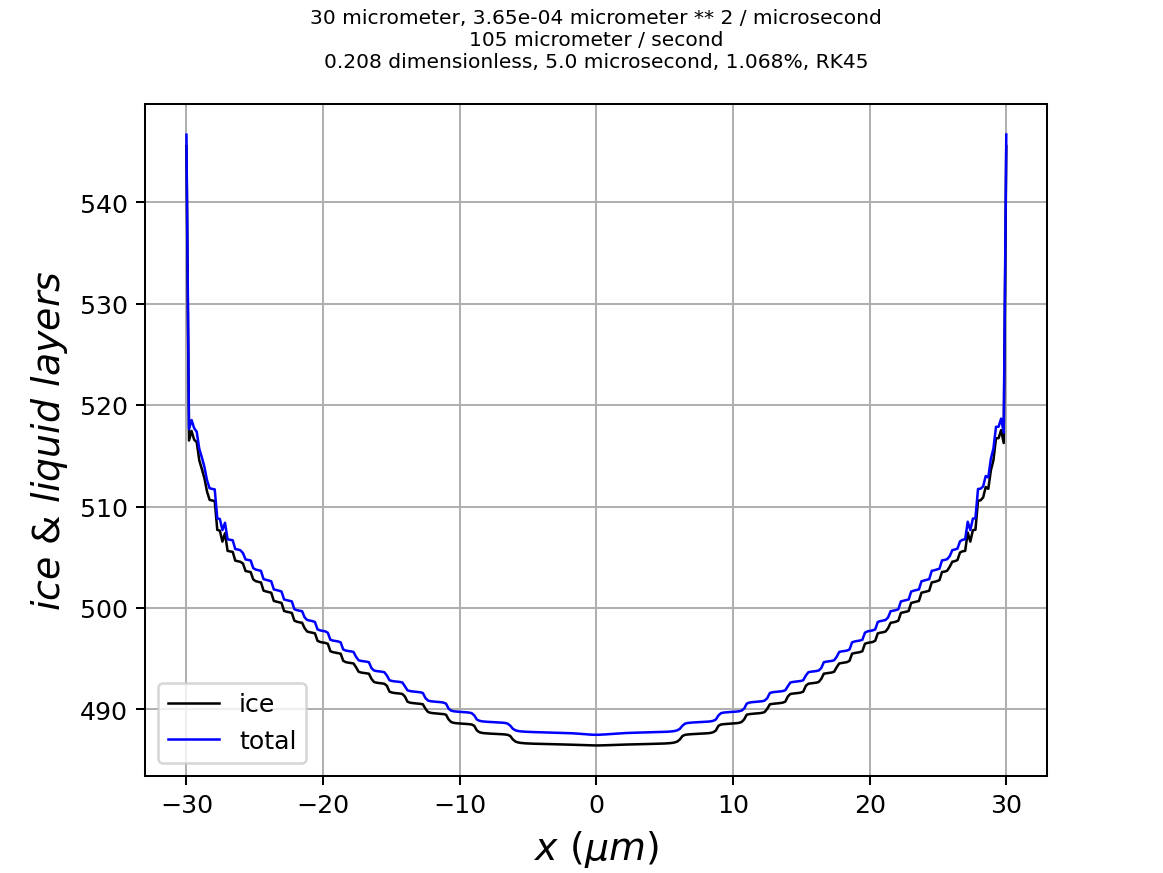

<IPython.core.display.Javascript object>


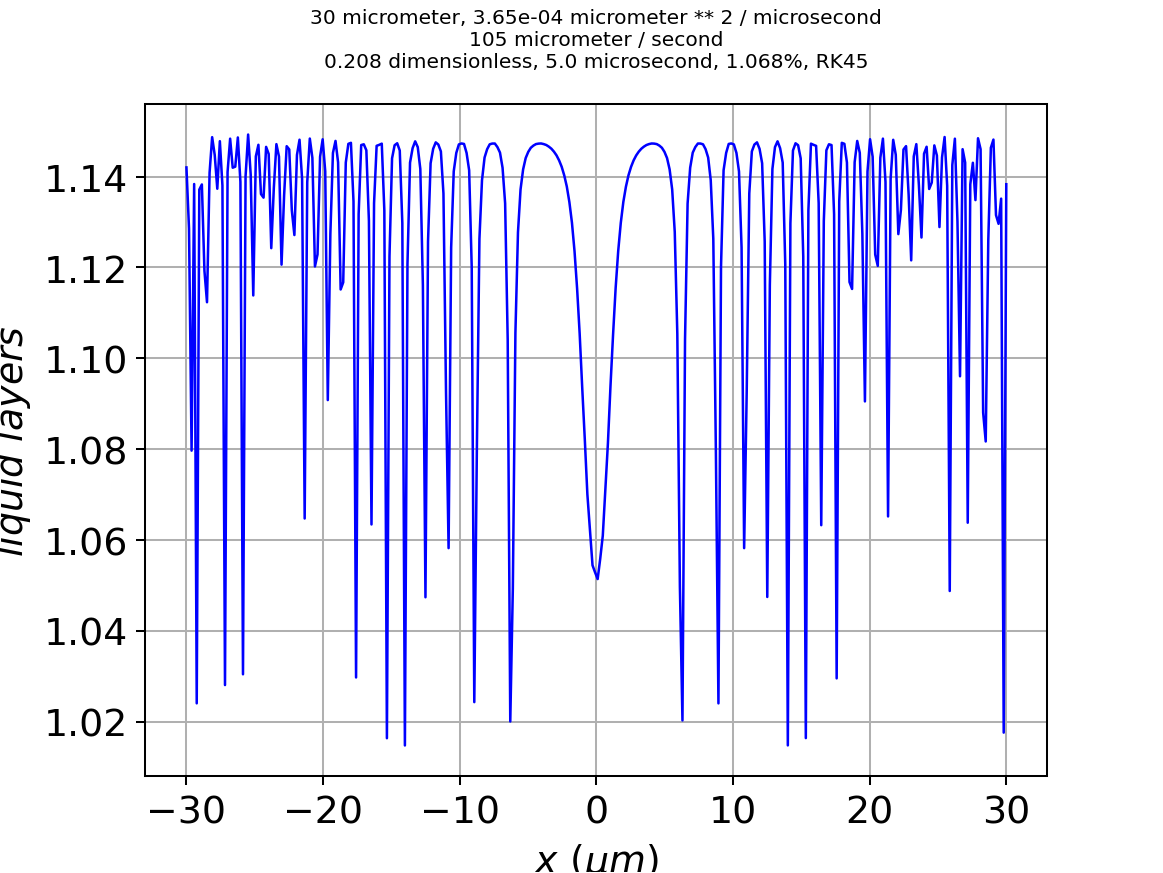

<IPython.core.display.Javascript object>


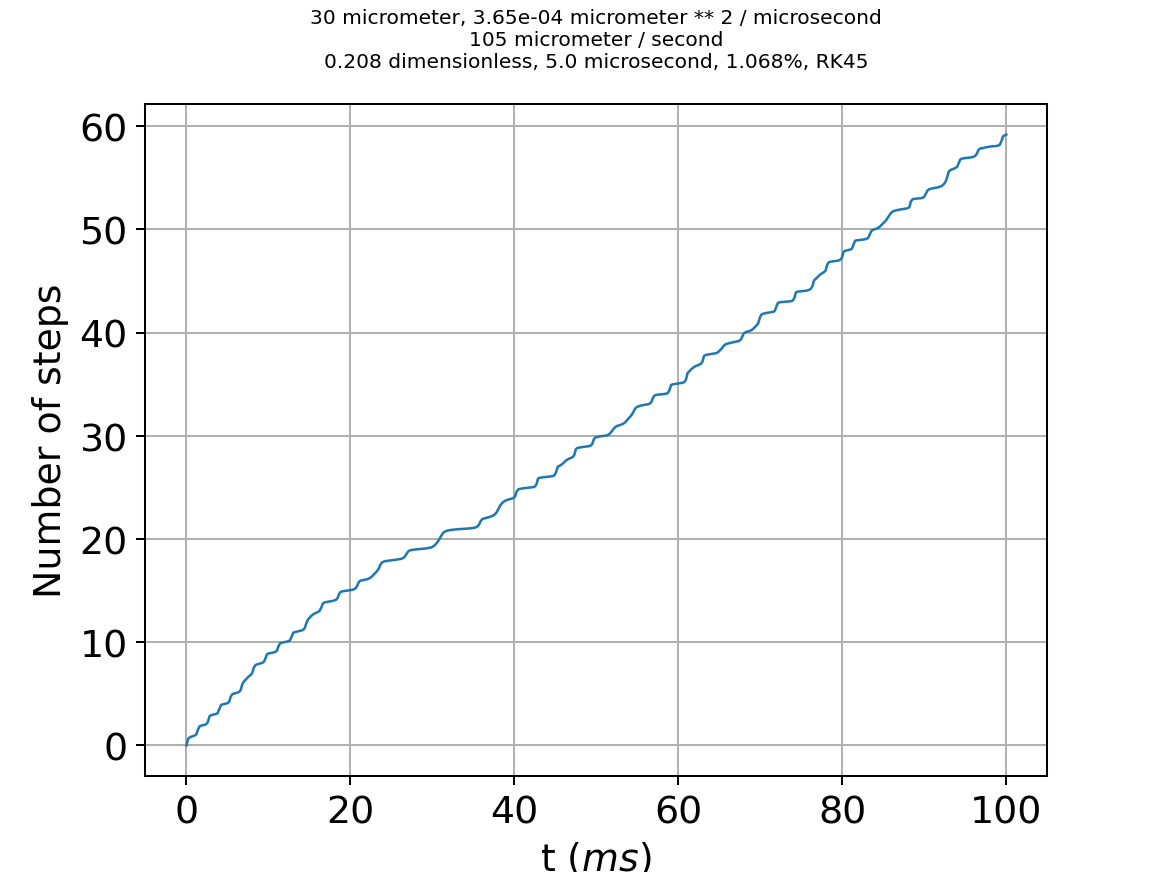

tau = 5 microsecond
c_r(%) = 1.068 dimensionless
final g_ice_QLC = 2.1234300722281607 micrometer / second
alpha relative to sigmaI_corner = 0.09722665165879857 dimensionless


<IPython.core.display.Javascript object>


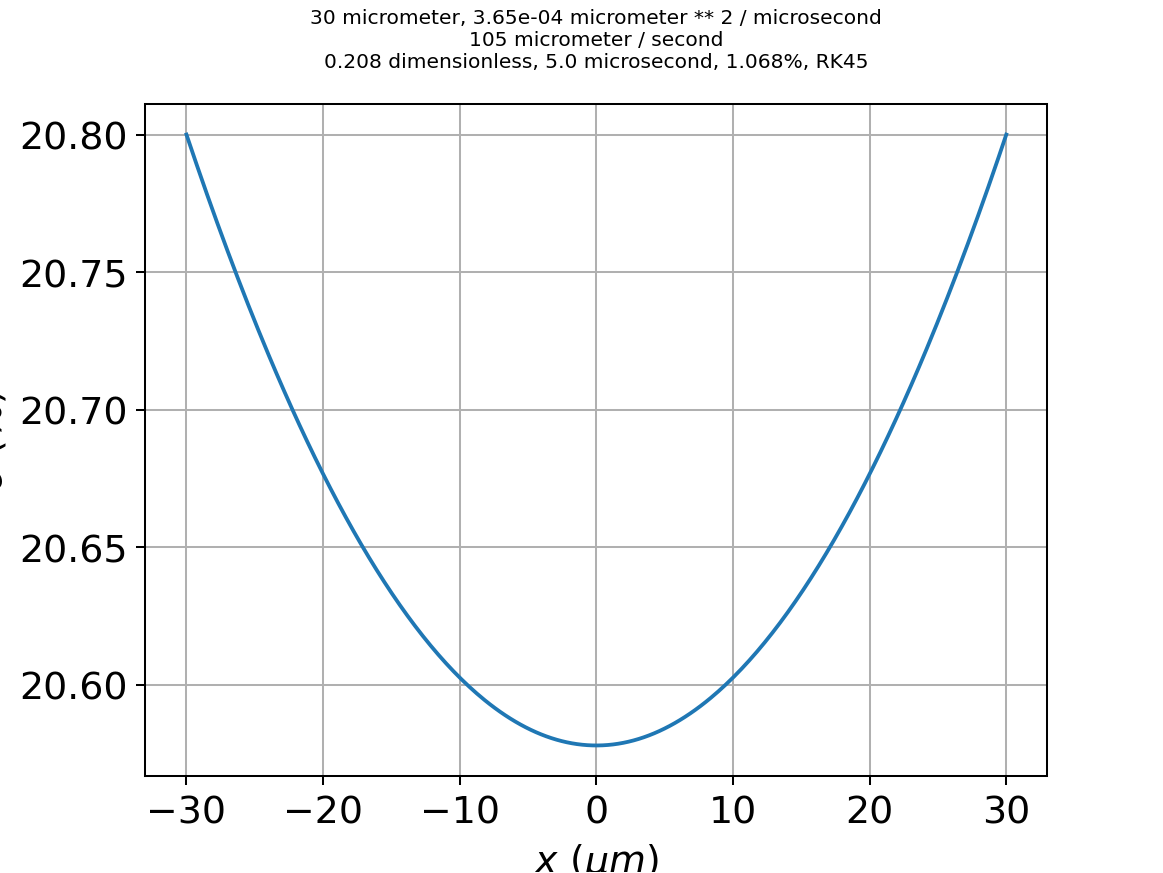

nsteps average of last 30.0 % ( 150 points) = 50.395664554153946
estimated lambda = 0.5952893024709047 micrometer
Done with scenario  1  out of  1
--------------------


/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


In [7]:
parameterlist = []
resultslist = []
icount = 0
for parameter_magnitudes in parameterlist_mag:
    
    # Counter 
    icount += 1

    # Size of the box
    L = AssignQuantity(parameter_magnitudes[0],'micrometer') 
    print('L =', L)

    # Surface diffusion coefficient
    D = AssignQuantity(parameter_magnitudes[1],'micrometer^2/microsecond') 
    print('D = ',D)

    # Kinetic velocity
    nu_kin = AssignQuantity(parameter_magnitudes[2],'micrometer / second')
    print('nu_kin = ',nu_kin)
    nu_kin_mlyperus = nu_kin/nmpermonolayer
    nu_kin_mlyperus.ito('1/microsecond')
    print('nu_kin_mlyperus =', nu_kin_mlyperus)

    # Supersaturation at the corner
    sigmaI_corner = AssignQuantity(parameter_magnitudes[3],'dimensionless')
    print('sigmaI_corner =', sigmaI_corner)
    
    # Supersaturation at the corner
    c_r_percent = AssignQuantity(parameter_magnitudes[4],'dimensionless')
    print('c_r_percent =', c_r_percent)
    c_r = c_r_percent/100
    
    # Just reporting the integration method
    print('odemethod =', odemethod)

    # Freezing time constant
    tau_eq = AssignQuantity(parameter_magnitudes[5],'microsecond')

    # Number of points on the ice surface
    Lx_reference = AssignQuantity(75,'micrometer')
    nx_crystal = int(6000*L/Lx_reference) # Resolution with explicit integration methods
    nx_crystal = int(2000*L/Lx_reference) # Reduced resolution for implicit methods
    nx_crystal = int(1500*L/Lx_reference) # 
    nx_crystal = int(1000*L/Lx_reference) # 
    nx_crystal = int(800*L/Lx_reference) # 
    if (nx_crystal % 2 == 1): nx_crystal -= 1
    print('nx (crystal) =', nx_crystal)
    x_QLC = np.linspace(-L,L,nx_crystal)
    
    # supersaturation over the ice surface
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)

    # Scaled version of the diffusion coefficient
    deltax = x_QLC[1]-x_QLC[0]
    print('Spacing of points on the ice surface =', deltax)
    Doverdeltax2 = D/deltax**2
    
    # Maximum time step according to the Princeton notes
    dtmax = 1/Doverdeltax2/2
    print('dtmax =', dtmax)

    # Estimating/deciding on how long to make the integration
    print('Estimating times for the trajectory run')
    L_reference = AssignQuantity(1,'millimeter')
    time_reference = AssignQuantity(1,'millisecond')
    tlast_estimated = (L*L_reference/D*time_reference)**.5 / 6
    tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
    tlast = tlast_estimated # Use this line to keep the estimated time
    tlast = AssignQuantity(100,'millisecond') # Use this line to override the estimated time
    print('   time (used) = ',tlast.to('msec'))
    tlast.ito('microsecond')

    # Number of time steps to report back
    ntimes = 500
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

    title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
#     print(title_params)

    # Solve the 1-D problem
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod=odemethod)
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

#   Report
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,title_params=title_params)
    print('tau =', tau_eq)
    print('c_r(%) =', c_r_percent)
    print('final g_ice_QLC =',g_ice_QLC)
    alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
    alpha = AssignQuantity(alpha,'dimensionless')
    print('alpha relative to sigmaI_corner =',alpha)

    plt.figure()
    plt.plot(x_QLC,sigmaI_QLC*100)
    plt.grid(True)
    plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title_params,fontsize=titlefontsize)

    lastfraction = 0.3
    itimes_almost_end = int(ntimes*(1-lastfraction))
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps_ss = np.mean(f[itimes_almost_end:-1])
    print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
    lambda_average = L/nsteps_ss
    print('estimated lambda =', lambda_average)
    results = [g_ice_QLC, lambda_average, alpha]
    resultslist.append(results)
    parameters = [L,D,nu_kin,sigmaI_corner,c_r_percent,tau_eq]
    parameterlist.append(parameters)
    print('Done with scenario ', icount,' out of ', len(parameterlist_mag))
    print('--------------------')

In [8]:
# # Repackaging the parameters
# L_list = np.empty(0)
# D_list = np.empty(0)
# nu_kin_list = np.empty(0)
# sigmaI_corner_list = np.empty(0)
# c_r_percent_list = np.empty(0)
# tau_eq_list = np.empty(0)
# for this_parameterset in parameterlist:
#     L_list = np.append(L_list,this_parameterset[0])
#     D_list = np.append(D_list,this_parameterset[1])
#     nu_kin_list = np.append(nu_kin_list,this_parameterset[2])
#     sigmaI_corner_list = np.append(sigmaI_corner_list,this_parameterset[3])
#     c_r_percent_list = np.append(c_r_percent_list,this_parameterset[4])
#     tau_eq_list = np.append(tau_eq_list,this_parameterset[5])
# c_r_list = c_r_percent_list/100
# print('parameters')
# print(L_list)
# print(D_list)
# print(nu_kin_list)
# print(sigmaI_corner_list)
# print(c_r_percent_list)
# print(tau_eq_list)

# zp_list = np.abs((D_list/c_r_list/nu_kin_list))**.5
# zp_list.ito('micrometer^.5')

# # Repackaging the results
# g_ice_QLC_list = np.empty(0)
# lambda_average_list = np.empty(0)
# alpha_list = np.empty(0)
# for this_resultset in resultslist:
#     g_ice_QLC_list = np.append(g_ice_QLC_list,this_resultset[0])
#     lambda_average_list = np.append(lambda_average_list,this_resultset[1])
#     alpha_list = np.append(alpha_list,this_resultset[2])
# print('\n results \n')
# print('g_ice_QLC_list =',g_ice_QLC_list,'\n')
# print('lambda_average_list =',lambda_average_list,'\n')
# print('alpha_list =',alpha_list,'\n')
# print('zp_list =',zp_list,'\n')

In [9]:
# # Getting lambda as a function of the z-parameter
# plt.figure()
# plt.plot(zp_list,lambda_average_list,'o')
# plt.xlabel('z ($\mu m ^{1/2}$)',fontsize=fontsize)
# plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid(True)

<IPython.core.display.Javascript object>


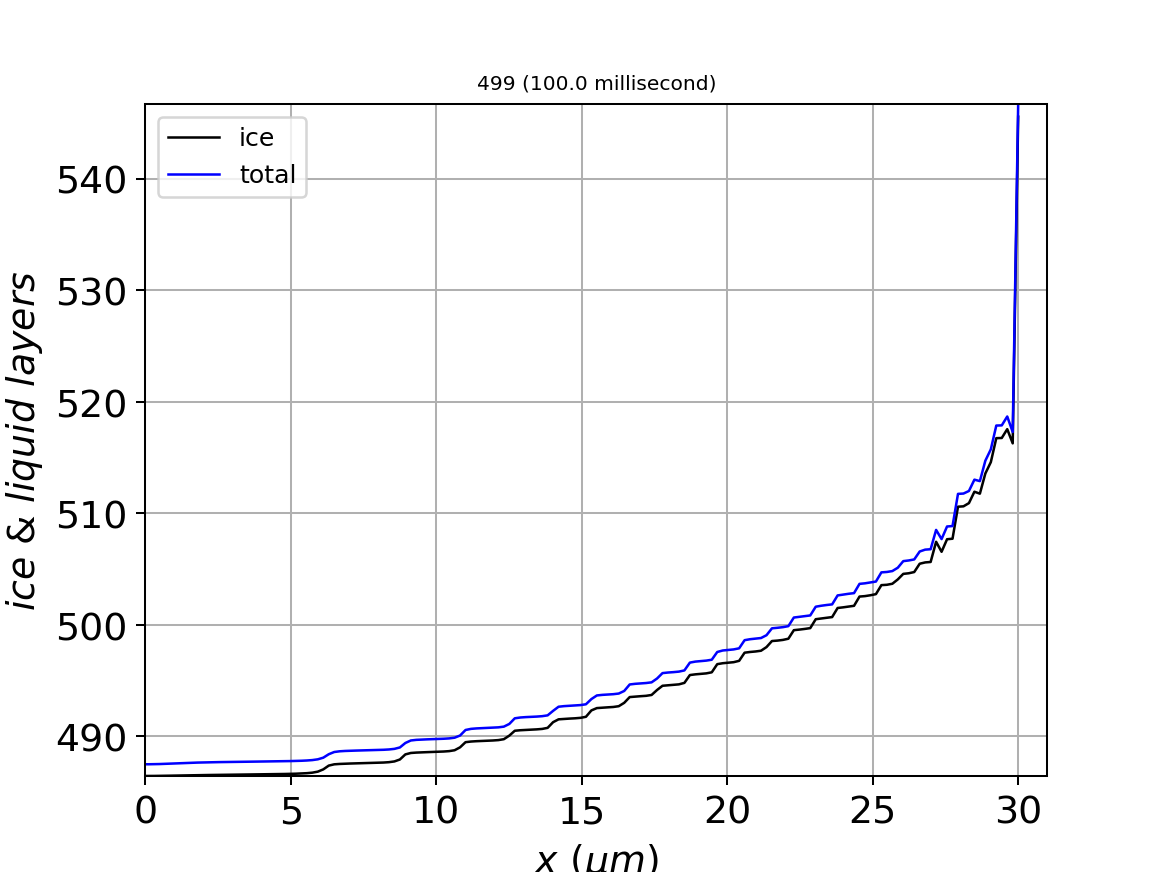

<IPython.core.display.Javascript object>


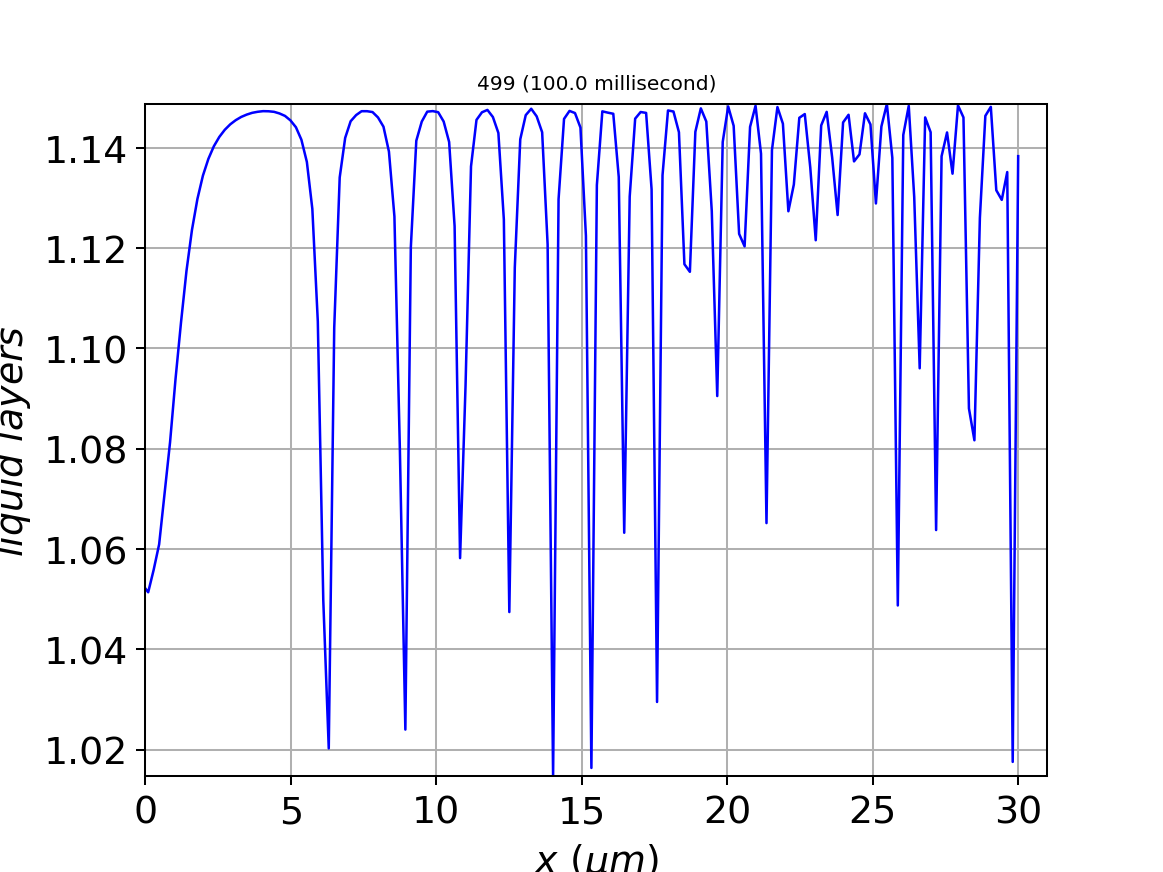

<IPython.core.display.Javascript object>


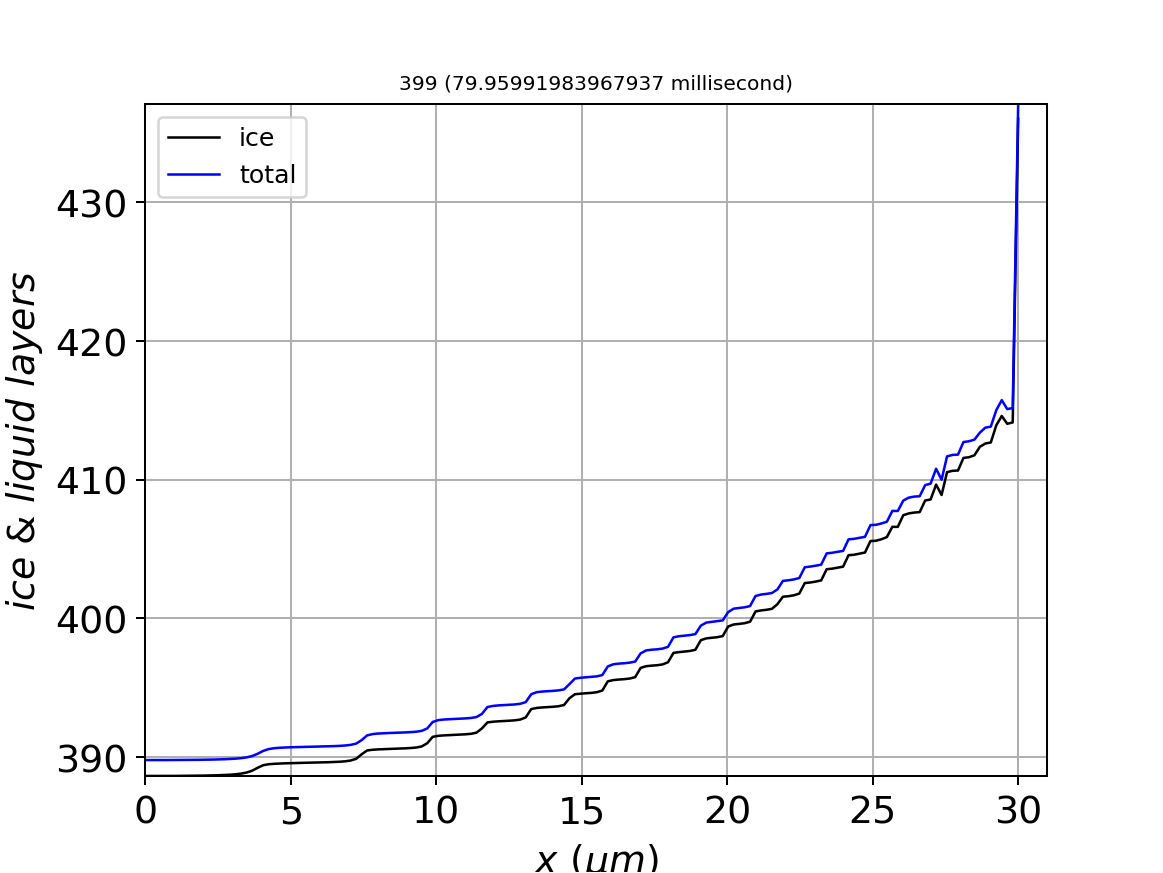

<IPython.core.display.Javascript object>


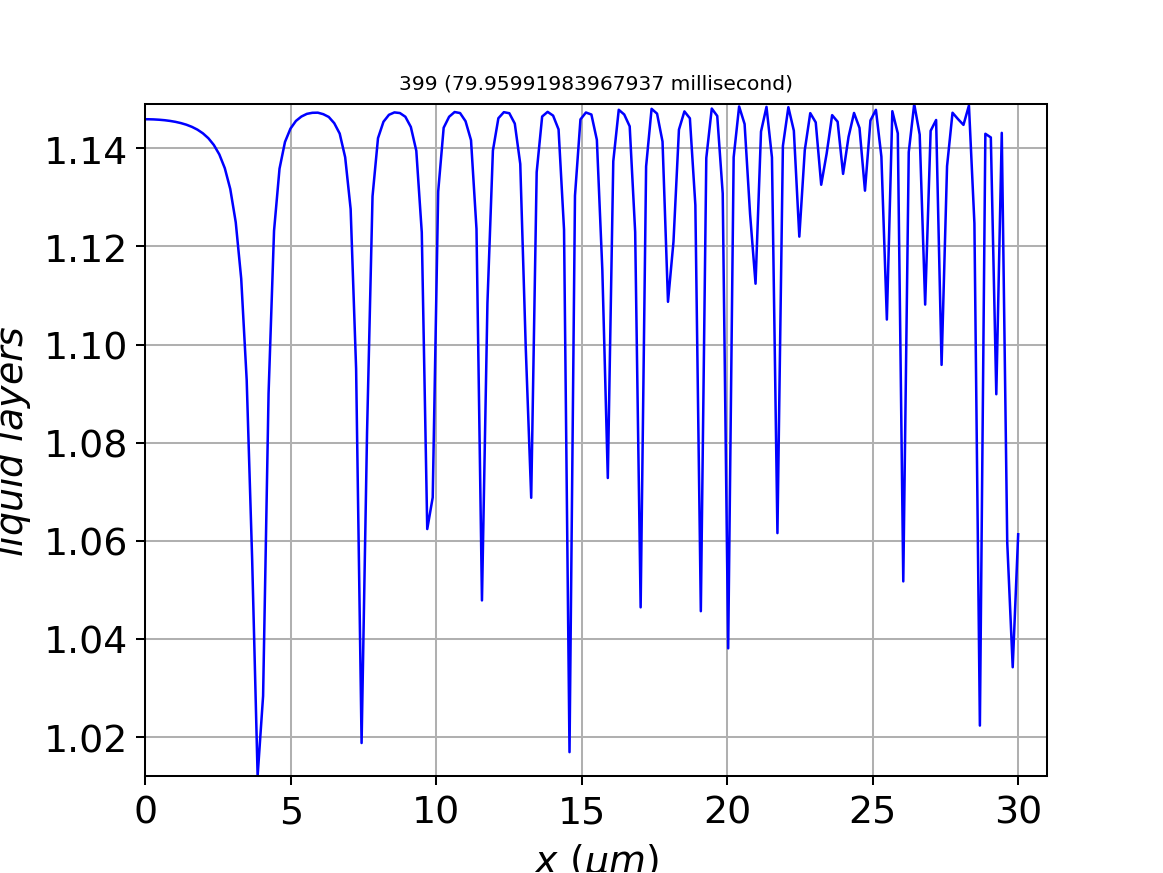

<IPython.core.display.Javascript object>


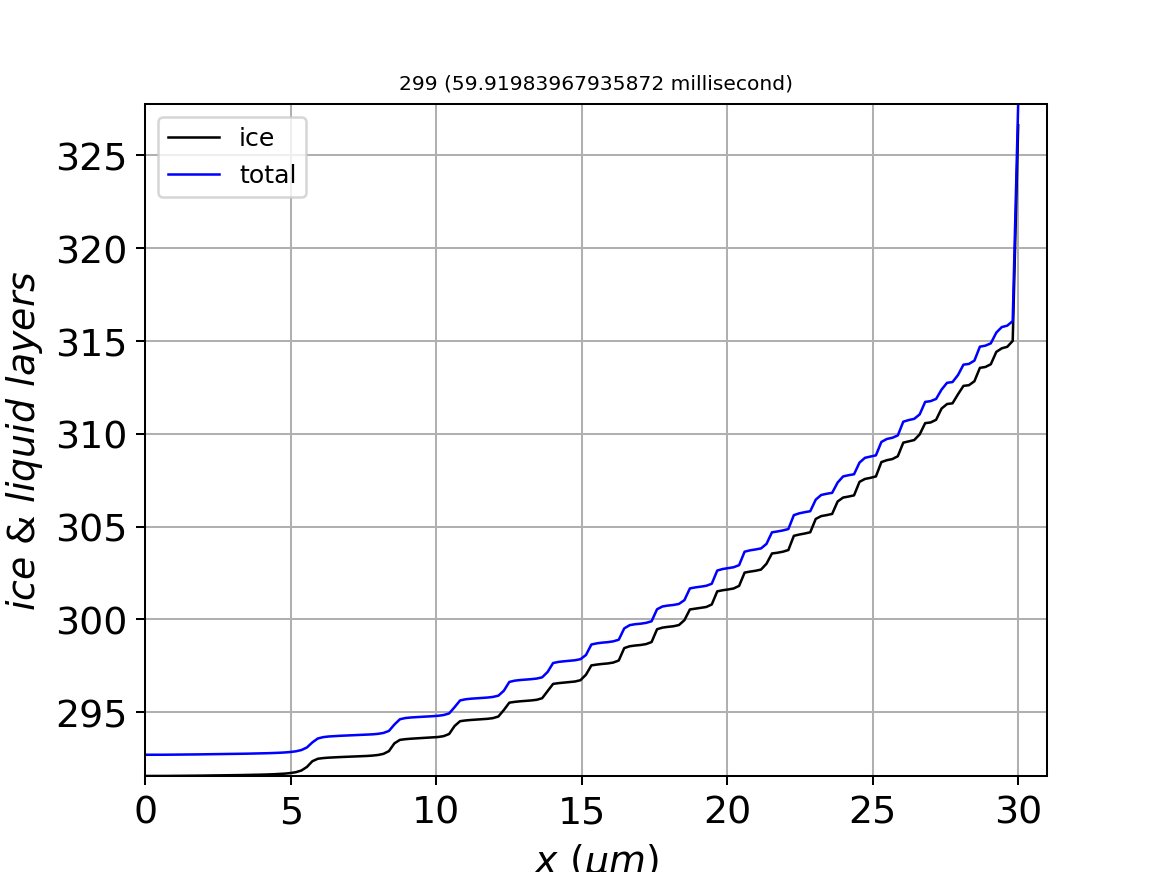

<IPython.core.display.Javascript object>


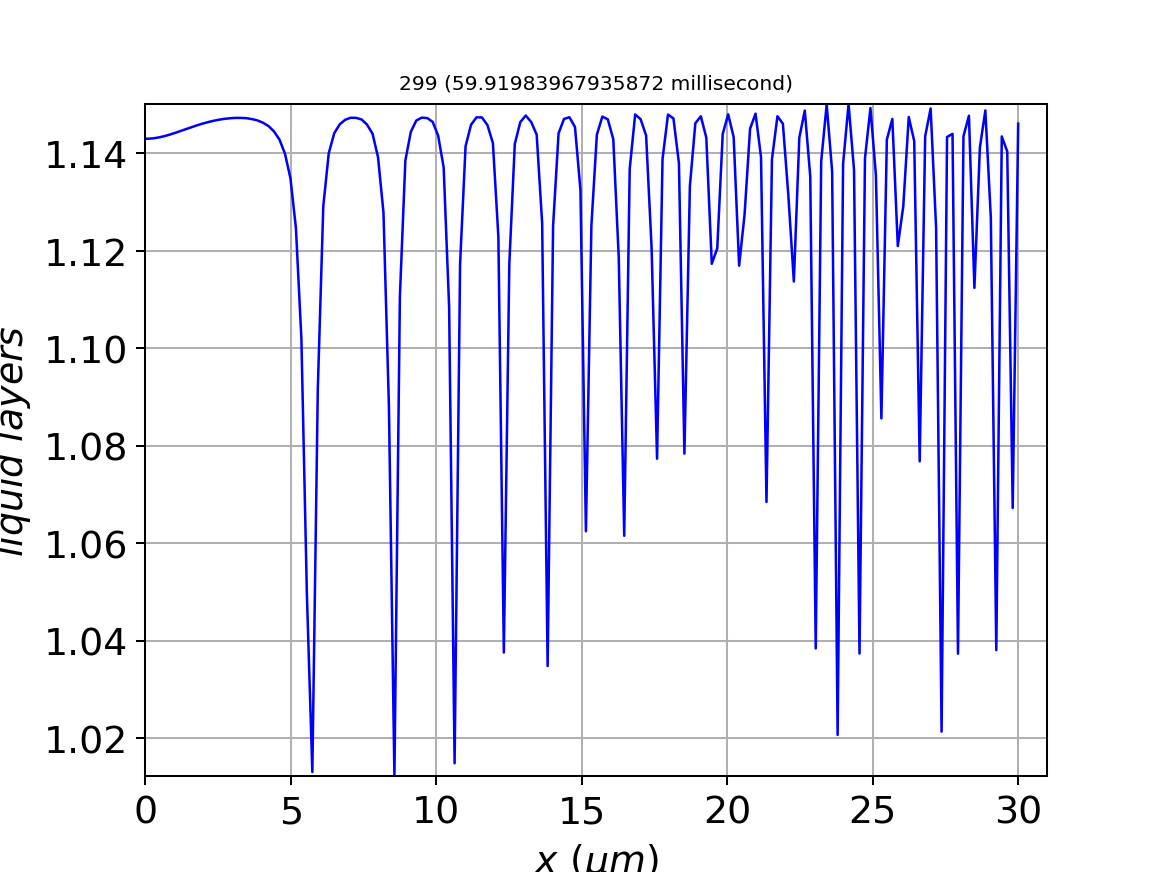

<IPython.core.display.Javascript object>


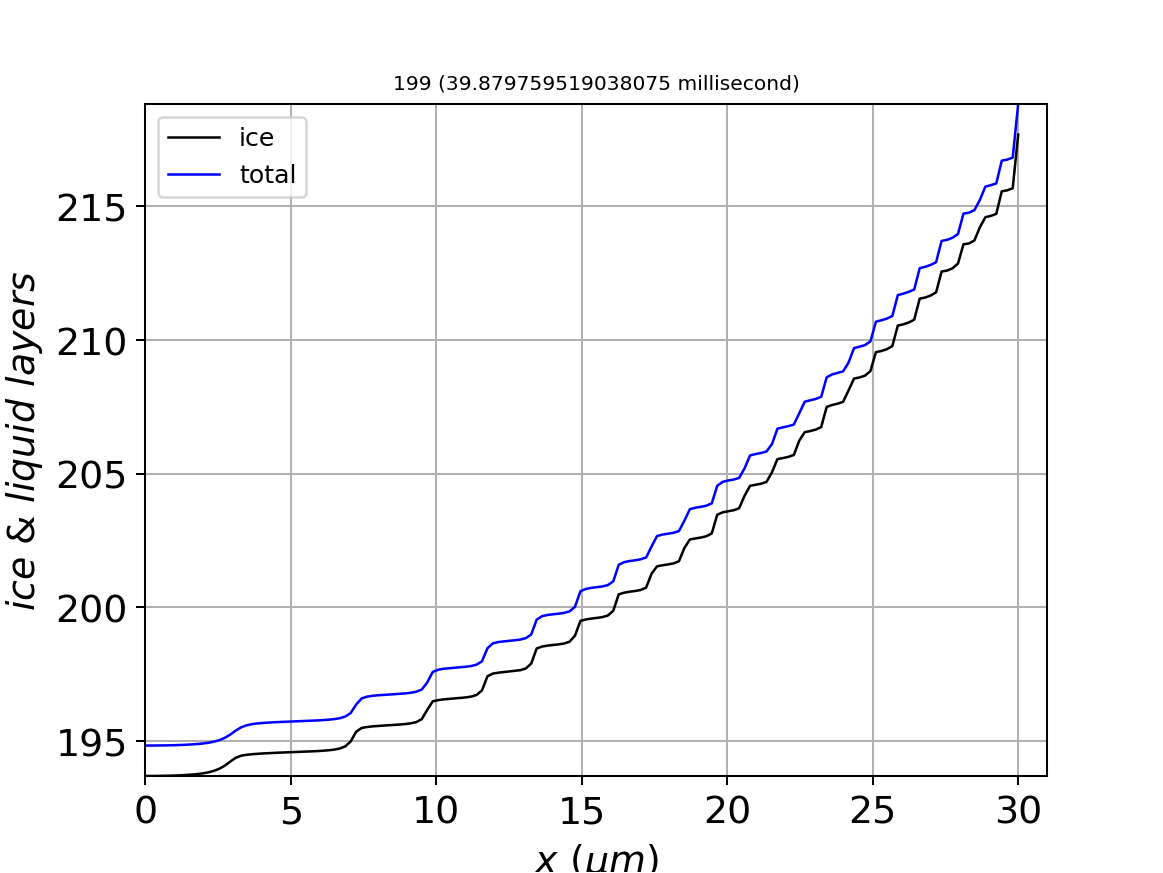

<IPython.core.display.Javascript object>


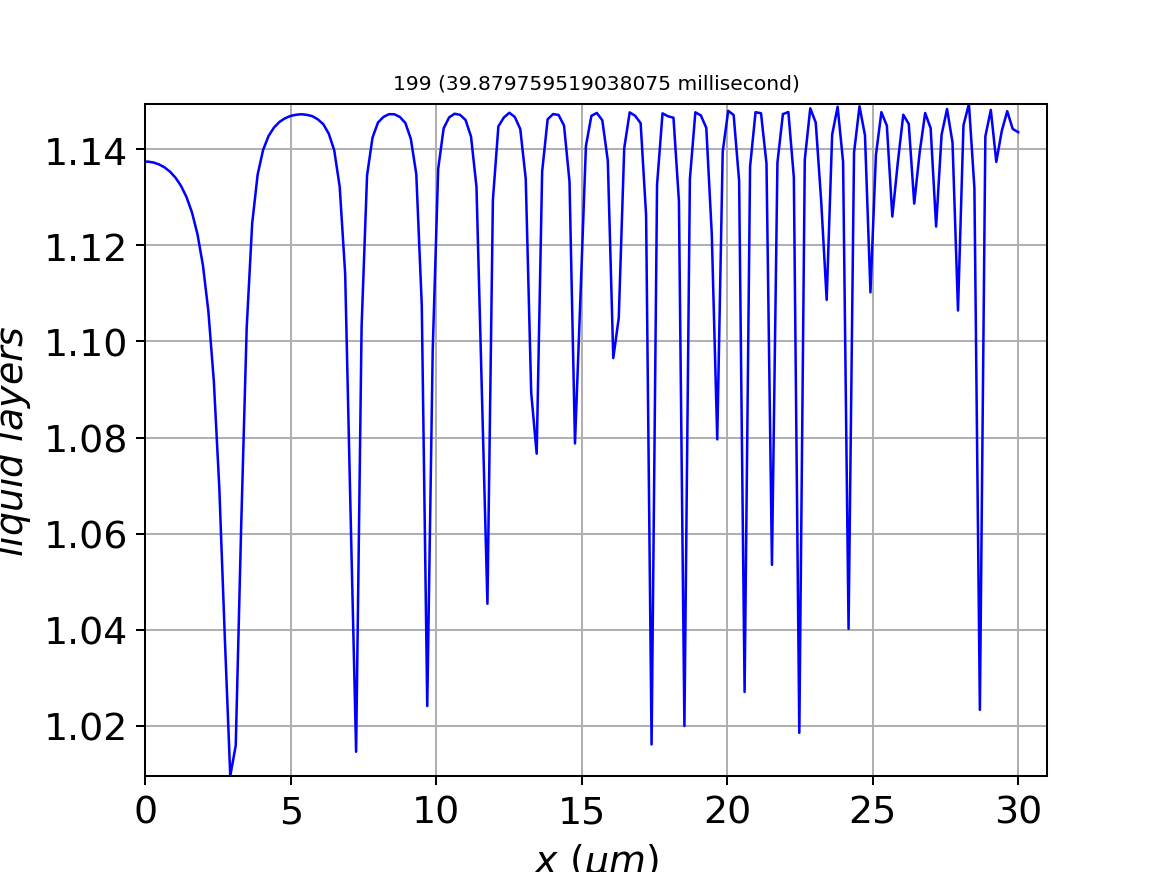

<IPython.core.display.Javascript object>


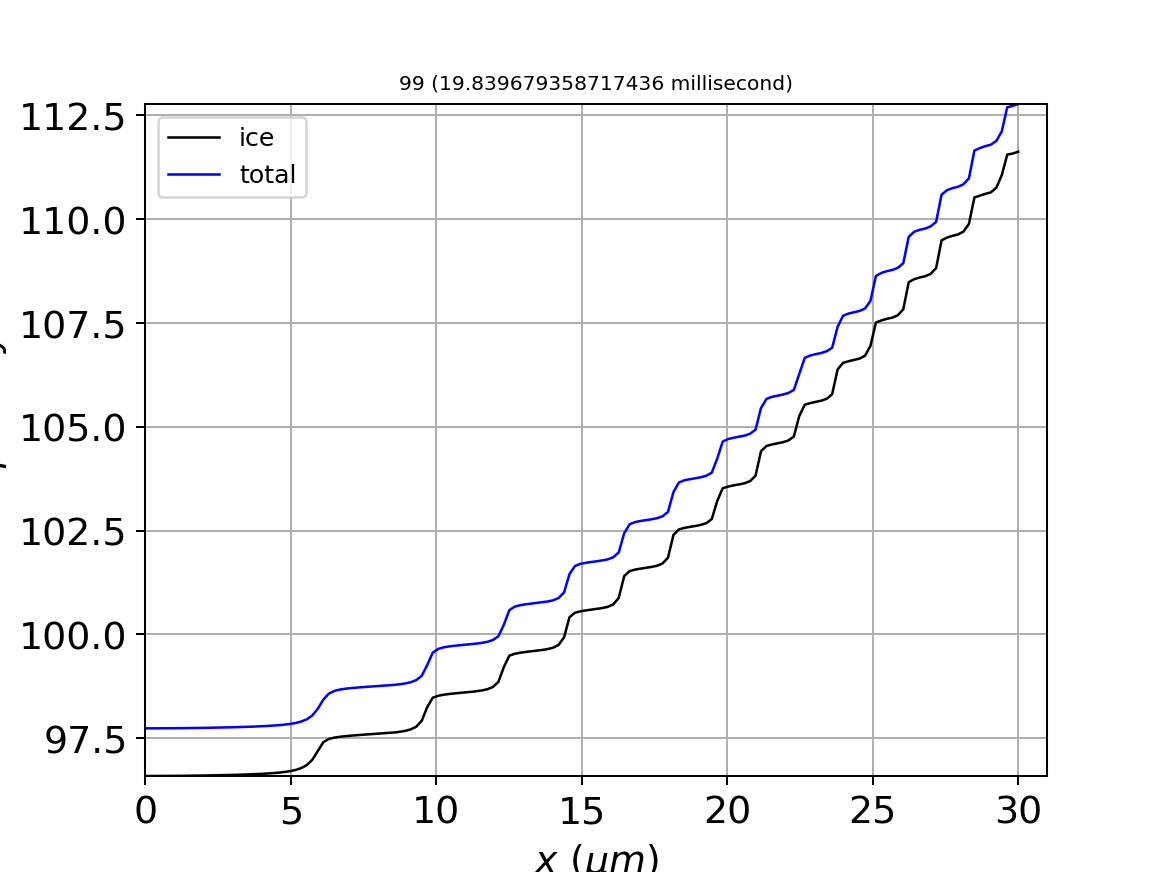

<IPython.core.display.Javascript object>


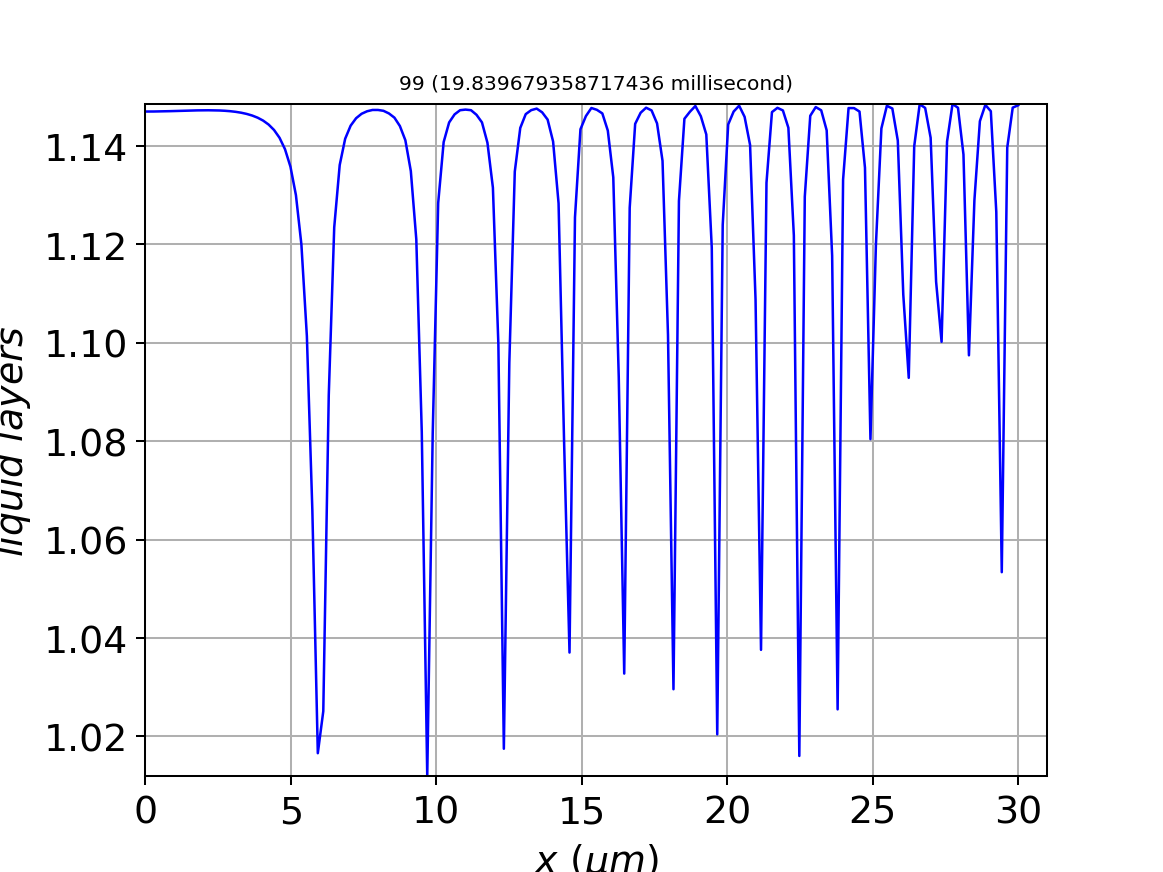

In [10]:
# Check out intermediate values
for itime in range(ntimes-1,0,-100):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[0,31])

In [11]:
# # Check out a range of times
# from importlib import reload
# reload(QLC)
# for itime in range(0,len(tkeep_1Darr)):
#     title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
#     g_ice_QLC = QLC.report_1d_growth_results(\
#         x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
#         graphics=True,Liquid=True,IceAndLiquid=False,tgraphics=False,title_params=title_params,itime=itime, \
#         xlim=[0,30])

In [12]:
# # See what we can learn about the last state
# scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus.magnitude, Doverdeltax2.magnitude, tau_eq.magnitude])
# nx = len(Ntotkeep_1D)
# ylast = np.array([NQLLkeep_1D,Ntotkeep_1D])
# ylast = np.reshape(ylast,2*nx)


### Exploring k-space solutions

In [13]:
# # See about the Fourier components of some of these solutions
# from scipy.fft import fft, ifft, rfft, irfft, fftfreq

# itime = 349
# print('Looking at time index', itime)
# print('corresponding to time', tkeep_1Darr[itime])

# # Take the real cosine transform of the total ice thickness
# aj_list = rfft(Ntotkeep_1D[itime,:]); naj_list = len(aj_list); print('naj_list',naj_list)

# # Regenerate
# Ntot_regen = irfft(aj_list); nx_Ntot_regen = len(Ntot_regen); print('nx_Ntot_regen',nx_Ntot_regen)
# imid_orig = int(len(Ntotkeep_1D[itime,:])/2)
# imid_regen = int(nx_Ntot_regen/2)
# # Ntot_regen -= Ntot_regen[imid_regen]-Ntotkeep_1D[itime,imid_orig]

# # Get the new x-axis for the full transform
# x_regen = x_QLC.magnitude[0:nx_Ntot_regen]+deltax.magnitude/2; print(len(x_regen))

# # Visualize
# plt.figure()
# plt.plot(x_QLC.magnitude, Ntotkeep_1D[itime,:], 'b', label='original', lw=linewidth)
# plt.plot(x_regen, Ntot_regen, 'b--', label='regenerated', lw=linewidth)
# plt.grid(True)
# plt.legend()

# # Similar for the QLL
# bj_list = rfft(NQLLkeep_1D[itime,:]); nbj_list = len(bj_list); print('nbj_list',nbj_list)
# NQLL_regen = irfft(bj_list); nx_NQLL_regen = len(NQLL_regen)
# # NQLL_regen -= NQLL_regen[imid_regen]-NQLLkeep_1D[itime,imid_orig]
# plt.figure()
# plt.plot(x_QLC.magnitude, NQLLkeep_1D[itime,:], 'k', label='original', lw=linewidth)
# plt.plot(x_regen, NQLL_regen, 'k--', label='regenerated', lw=linewidth)
# plt.grid(True)
# plt.legend()

In [14]:
# jmax = 100
# aj_list_head = aj_list[0:jmax]; #print('head', aj_list_head)
# aj_list_tail = aj_list[-jmax:-1]; #print('tail', aj_list_tail)
# aj_tr_list = np.append(aj_list_head,aj_list_tail)
# print('Old alist length', len(aj_list))
# print('New alist length', len(aj_tr_list))
# Ntot_tr_regen = irfft(aj_tr_list)
# nx_Ntot_tr_regen = len(Ntot_tr_regen)
# print('Old x length', nx_Ntot_regen)
# print('New x length', nx_Ntot_tr_regen)
# rescale = nx_Ntot_tr_regen/nx_Ntot_regen
# Ntot_tr_regen *= rescale
# imid_tr_regen = int(nx_Ntot_tr_regen/2)
# Ntot_tr_regen -= Ntot_tr_regen[imid_tr_regen]-Ntotkeep_1D[itime,imid_orig]
# x_tr_regen = np.linspace(-L.magnitude,L.magnitude,nx_Ntot_tr_regen)

# plt.figure()
# plt.plot(x_QLC.magnitude, Ntotkeep_1D[itime,:], 'b', label='original', lw=linewidth)
# plt.plot(x_tr_regen,Ntot_tr_regen,'k--', label='truncated', lw=linewidth)
# plt.xlabel('x ($\mu m$)',fontsize=fontsize)
# plt.legend()
# plt.title('Ntot',fontsize=titlefontsize)
# plt.grid(True)
# print(np.max(Ntot_regen)-np.min(Ntot_regen))
# print(np.max(Ntot_tr_regen)-np.min(Ntot_tr_regen))

# bj_list_head = bj_list[0:jmax]; #print('head', aj_list_head)
# bj_list_tail = bj_list[-jmax:-1]; #print('tail', aj_list_tail)
# bj_tr_list = np.append(bj_list_head,bj_list_tail)
# print('Old blist length', len(bj_list))
# print('New blist length', len(bj_tr_list))
# NQLL_tr_regen = irfft(bj_tr_list)
# nx_NQLL_tr_regen = len(NQLL_tr_regen)
# print('Old x length', nx_NQLL_regen)
# print('New x length', nx_NQLL_tr_regen)
# NQLL_tr_regen *= rescale
# # NQLL_tr_regen -= NQLL_tr_regen[imid_tr_regen]-NQLLkeep_1D[itime,imid_orig]

# plt.figure()
# plt.plot(x_QLC.magnitude, NQLLkeep_1D[itime,:], 'b', label='original', lw=linewidth)
# plt.plot(x_tr_regen,NQLL_tr_regen,'k--', label='truncated', lw=linewidth)
# plt.xlabel('x ($\mu m$)',fontsize=fontsize)
# plt.legend()
# plt.title('NQLL',fontsize=titlefontsize)
# plt.grid(True)

In [15]:
# DoverdeltaX2 = Doverdeltax2.magnitude
# l = len(Ntotkeep_1D[itime,:]); print('l',l)
# Dcoefficient1 = 4*DoverdeltaX2/l**2*np.pi**2; print('Dcoefficient1', Dcoefficient1)
# Dcoefficient2 = np.pi**2 * D/L**2; print('Dcoefficient2', Dcoefficient2)
# print(Dcoefficient2/Dcoefficient1)
# rescale2 = len(bj_tr_list)/len(bj_list)

# # Diffusion term based on a truncated FT
# j_tr_list = np.array([j for j in range(len(bj_tr_list))])
# j2_tr_list = np.array(j_tr_list)**2
# cj_tr_list = bj_tr_list*j2_tr_list
# Dterm_tr = -Dcoefficient1 * irfft(cj_tr_list) * rescale2
# print(len(Dterm_tr))

# # Diffusion term based on the full FT
# j_list = np.array([j for j in range(len(bj_list))])
# j2_list = np.array(j_list)**2
# cj_list = bj_list*j2_list
# Dterm = -Dcoefficient1  * irfft(cj_list)
# print(len(Dterm))

# # Diffusion term based on zeroing out high j-values
# j_list = np.array([j for j in range(len(bj_list))])
# j2_list = np.array(j_list)**2
# j2_list[(j_list>jmax)] = 0
# cj_zeroed_list = bj_list*j2_list
# Dterm_zeroed = -Dcoefficient1  * irfft(cj_zeroed_list)
# print(len(Dterm))

# # Diffusion based on x-space
# NQLL0 = NQLLkeep_1D[itime,:]
# dy = np.empty(np.shape(NQLL0))
# for i in range(1,len(NQLL0)-1):
#     dy[i] = DoverdeltaX2*(NQLL0[i-1]-2*NQLL0[i]+NQLL0[i+1])
# dy[0]  = DoverdeltaX2*(NQLL0[-1] -2*NQLL0[0] +NQLL0[1]) # Periodic BC
# dy[-1] = DoverdeltaX2*(NQLL0[-2] -2*NQLL0[-1]+NQLL0[0])

In [16]:
# plt.figure()
# plt.plot(x_regen,dy,'g', label='x-space', lw=linewidth)
# plt.plot(x_regen,Dterm,'k', label='full FT', lw=linewidth)
# # plt.plot(x_tr_regen,Dterm_tr,'b--', label='truncated', lw=linewidth)
# plt.plot(x_regen,Dterm_zeroed,'r--', label='zeroed', lw=linewidth)
# plt.legend()
# plt.grid(True)
# plt.title('Diffusion term',fontsize=titlefontsize)

Probing itime = -65
beta_trans = 0.2493280028431807 dimensionless


<IPython.core.display.Javascript object>


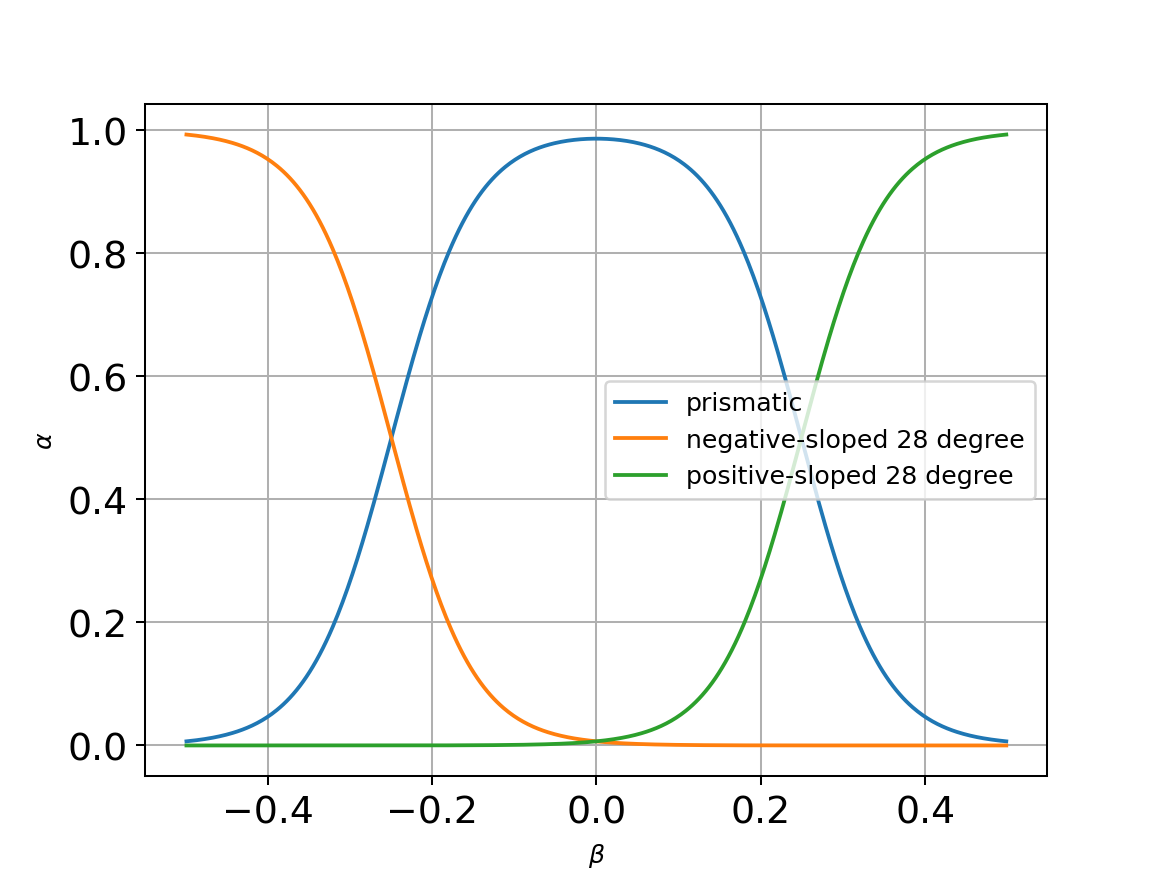

<IPython.core.display.Javascript object>


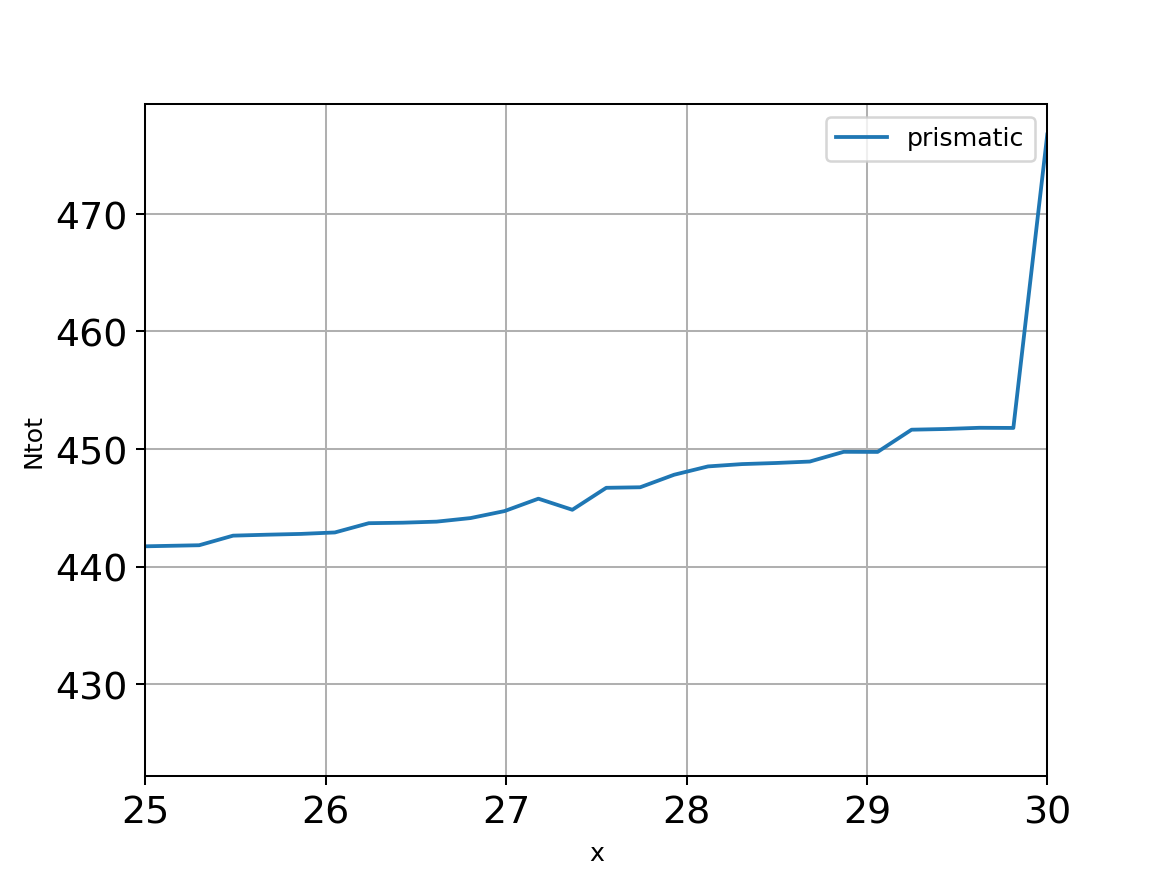

<IPython.core.display.Javascript object>


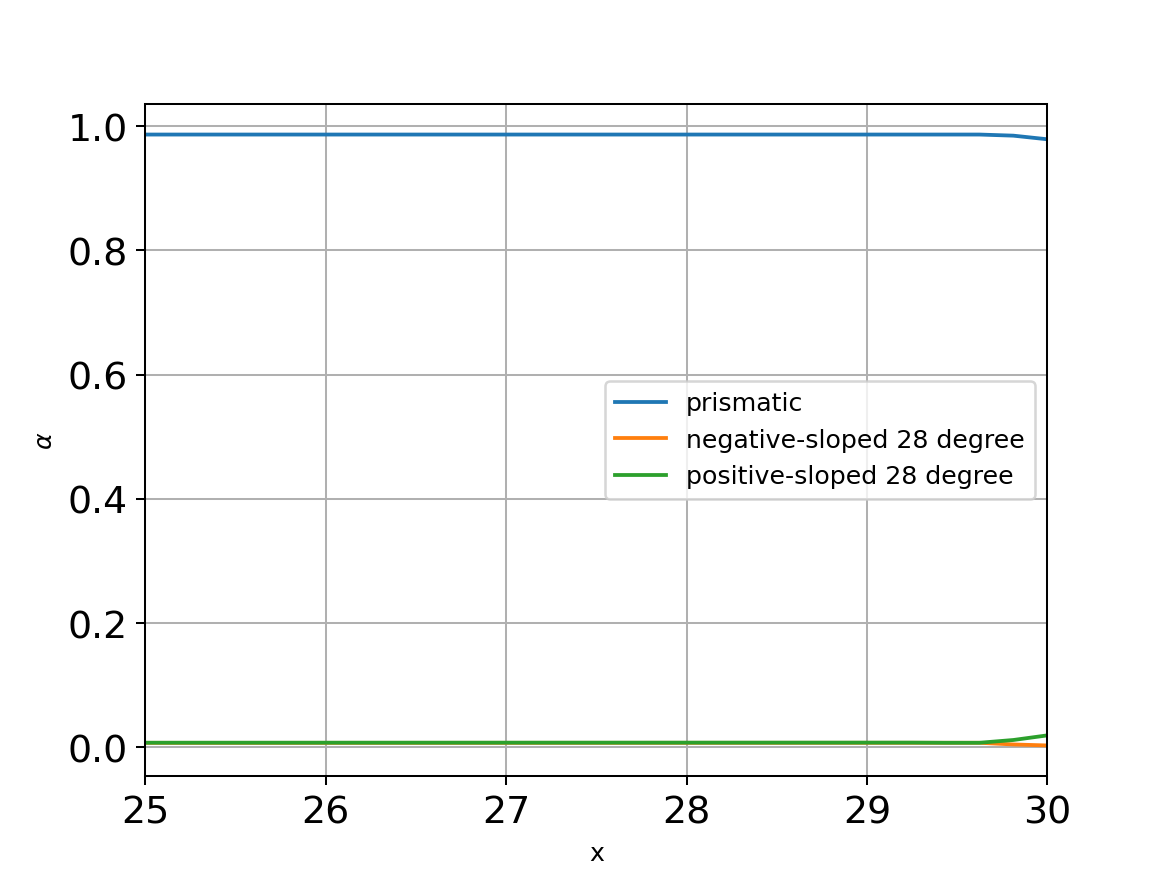

0.0716197243913529


<IPython.core.display.Javascript object>


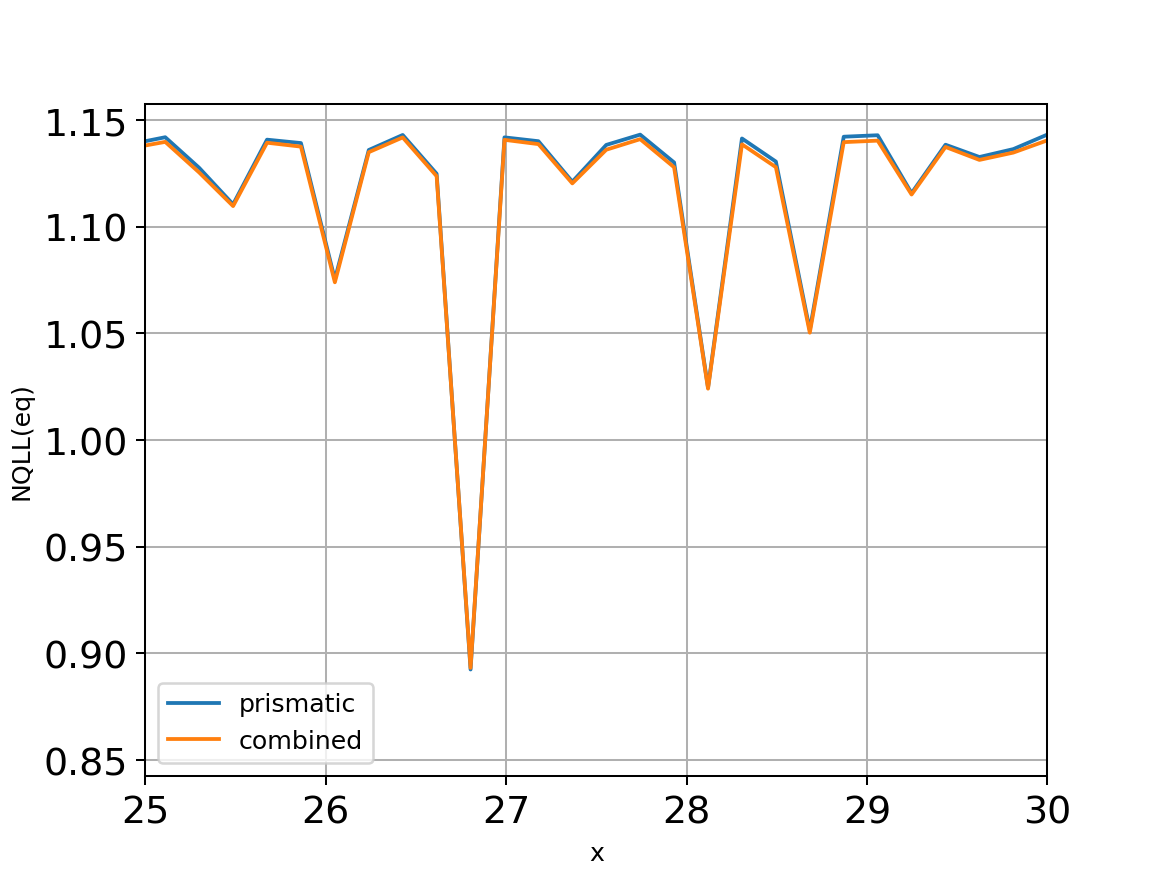

<IPython.core.display.Javascript object>


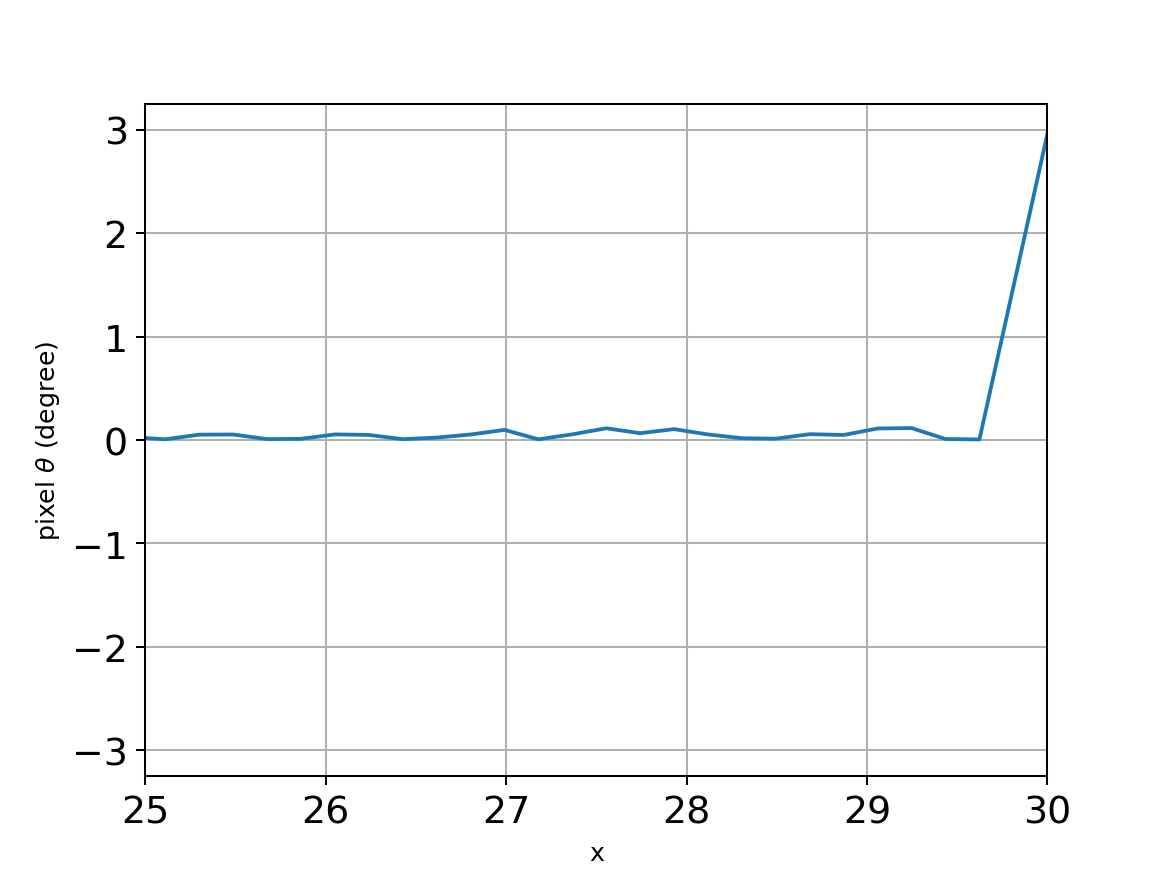

<IPython.core.display.Javascript object>


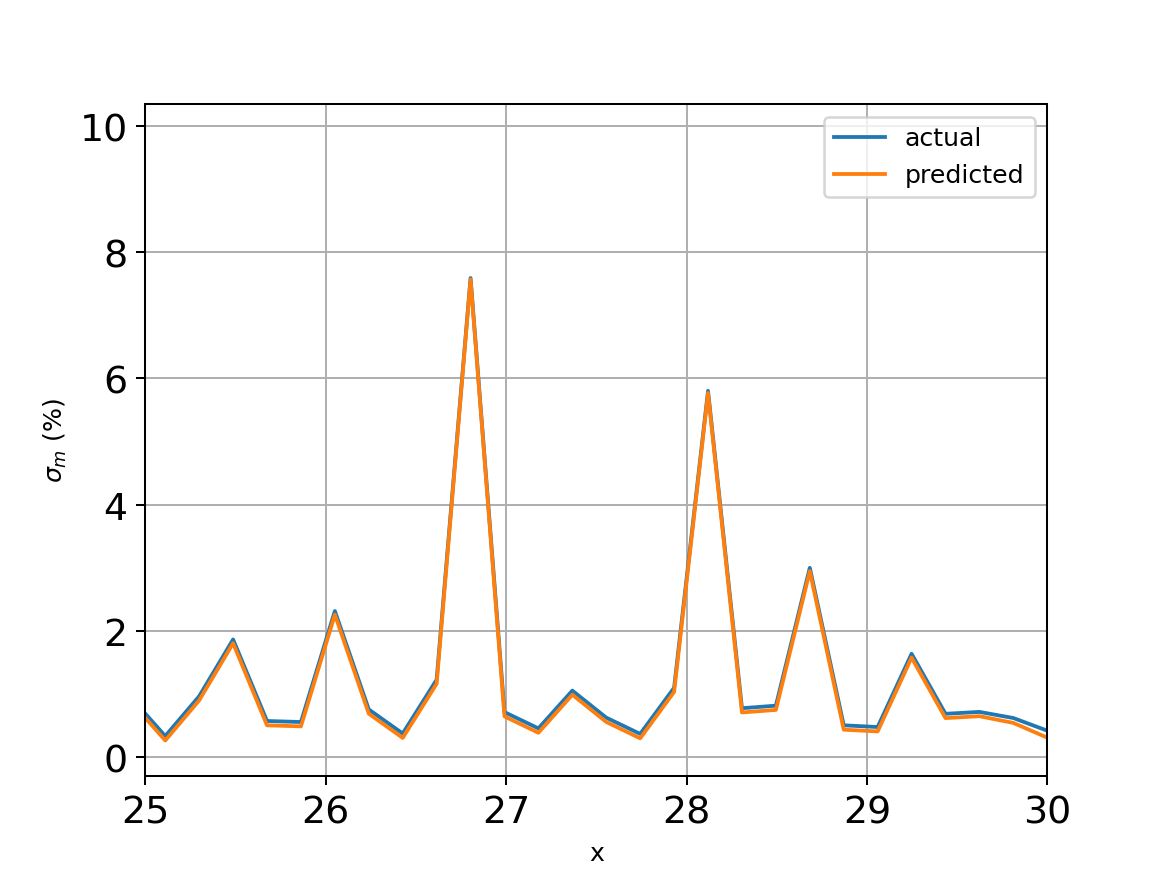

(25.0, 30.0)

In [17]:
# Probing the possibilities of multiple facet types
itime = -65
print('Probing itime =',itime)
Ntot_pr = Ntotkeep_1D[itime,:]
NQLL_pr = NQLLkeep_1D[itime,:]
xleft = 25
xright = 30

# This is a sigmoid function
def get_alpha(beta,beta_trans,delta_beta):
    alpha = 1-1/(1+np.exp(-(beta-beta_trans)/delta_beta))
    return alpha

# This is just to get a visual on the partitioning among the three facets (alpha)
theta = AssignQuantity(28, 'degrees')
# theta = AssignQuantity(90-28, 'degrees')
beta_trans = np.sin(theta/2)/np.cos(theta/2)
print('beta_trans =', beta_trans)
beta = np.linspace(-beta_trans*2,beta_trans*2,500)
delta_beta = beta_trans/5
alpha_pyneg = get_alpha(beta,-beta_trans,delta_beta)
alpha_pypos = 1-get_alpha(beta, beta_trans,delta_beta)
alpha_pr = 1 - alpha_pyneg - alpha_pypos

plt.figure()
plt.plot(beta,alpha_pr,label='prismatic')
plt.plot(beta,alpha_pyneg,label='negative-sloped '+str(theta))
plt.plot(beta,alpha_pypos,label='positive-sloped '+str(theta))
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.grid(True)
plt.legend()

# Now we'll work with the Ntot data of interest
h_pr = AssignQuantity(0.389,'nm')
h_py = h_pr
Ntot_pyneg = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr -np.sin(theta)*x_QLC)
Ntot_pypos = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr +np.sin(theta)*x_QLC)

plt.figure()
plt.plot(x_QLC,Ntot_pr,label='prismatic')
# plt.plot(x_QLC,Ntot_pyneg,label='negative-sloped'+str(theta))
# plt.plot(x_QLC,Ntot_pypos,label='positive-sloped'+str(theta))
plt.xlabel('x')
plt.ylabel('Ntot')
plt.grid(True)
plt.legend()
plt.xlim([xleft,xright])

z_pr = h_pr * Ntot_pr
dx = x_QLC[1]-x_QLC[0]
# beta = np.diff(z_pr)/dx
beta = np.gradient(z_pr,dx)
beta.ito('dimensionless')
alpha_pyneg = get_alpha(beta,-beta_trans,delta_beta)
alpha_pypos = 1-get_alpha(beta, beta_trans,delta_beta)
alpha_pr = 1 - alpha_pyneg - alpha_pypos

plt.figure()
plt.plot(x_QLC,alpha_pr,label='prismatic')
plt.plot(x_QLC,alpha_pyneg,label='negative-sloped '+str(theta))
plt.plot(x_QLC,alpha_pypos,label='positive-sloped '+str(theta))
plt.xlabel('x')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.grid(True)
plt.xlim([xleft,xright])

Nstar_pr = Nstar
Nstar_py = Nstar_pr*.5; print(Nstar_py)
NQLL_eq_pr    = Nbar - Nstar_pr*np.sin(2*np.pi*Ntot_pr)
NQLL_eq_pyneg = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pyneg)
NQLL_eq_pypos = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pypos)
NQLL_eq = alpha_pr*NQLL_eq_pr + alpha_pyneg*NQLL_eq_pyneg + alpha_pypos*NQLL_eq_pypos

plt.figure()
plt.plot(x_QLC,NQLL_eq_pr,   label='prismatic')
# plt.plot(x_QLC,NQLL_eq_pyneg,label='negative-sloped '+str(theta))
# plt.plot(x_QLC,NQLL_eq_pypos,label='positive-sloped '+str(theta))
plt.plot(x_QLC,NQLL_eq,label='combined')
plt.xlabel('x')
plt.ylabel('NQLL(eq)')
plt.legend()
plt.grid(True)
plt.xlim([xleft,xright])

# plt.figure()
# plt.plot(x_QLC,NQLL_eq-NQLL_eq_pr,label='combined-'+str(theta))
# plt.xlabel('x')
# plt.ylabel('NQLL(eq)')
# plt.legend()
# plt.grid(True)
# plt.xlim([xleft,xright])

# slopes = dx.magnitude*np.ones(len(x_QLC)) + 1j*beta.magnitude*dx.magnitude
slopes = np.ones(len(x_QLC)) + 1j*beta.magnitude
angles = AssignQuantity(np.angle(slopes),'radian')
angles.ito('degree')

plt.figure()
plt.plot(x_QLC,angles.magnitude)
plt.xlabel('x')
plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+')')
plt.grid(True)
plt.xlim([xleft,xright])

m_actual = (NQLL_pr-(Nbar-Nstar))/(2*Nstar)
sigma_m_actual = sigmaI_QLC - m_actual * sigma0
Nstar_est = alpha_pr*Nstar_pr + alpha_pyneg*Nstar_py + alpha_pypos*Nstar_py
m_predicted = (NQLL_pr -(Nbar-Nstar_est))/(2*Nstar_est)
sigma_m_predicted = sigmaI_QLC - m_predicted * sigma0

plt.figure()
plt.plot(x_QLC,sigma_m_actual*100,label='actual')
plt.plot(x_QLC,sigma_m_predicted*100,label='predicted')
plt.xlabel('x')
plt.ylabel(r'$\sigma_m$ (%)')
plt.grid(True)
plt.legend()
plt.xlim([xleft,xright])